In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Stats
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import scipy.stats as stats

## Plotting 
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Fig utils 
from fig_utils import get_score_bin

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Remove subversion on gene id
ConSplice_df["gene_id"] = ConSplice_df.gene_id.apply(lambda x: x.strip().split(".")[0])

In [6]:
## Convert info to dict
by_gene_ConSplice_scores = ConSplice_df[["gene_id","max_exon_number","cds_exon_count",consplice_col]].set_index("gene_id").transpose().to_dict()

In [7]:
## Load VG values
vg_df = pd.read_csv("../data/Vg.gene_level.ANEVA_tableS1.weighted_harmonic_mean.txt", header = 1, sep="\t", index_col = False)

In [8]:
## Add ConSpliec scores to VG values by gene
vg_df["constraint_percentile"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]][consplice_col] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)
vg_df["max_exon_number"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]]["max_exon_number"] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)
vg_df["cds_exon_count"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]]["cds_exon_count"] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)


In [9]:
## Get the splicing constarint decile for each variant
vg_df["constraint_percentile_bin"] = vg_df.apply(get_score_bin, score_column = "constraint_percentile", axis = 1)

In [10]:
## Update bin mapping for plotting
order = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]

bin_mapping = dict()
for i, b in enumerate(order):
    bin_mapping[b] = i 

bin_mapping["-1.0"] = -1.0


vg_df["constraint_percentile_bin_int"] = vg_df["constraint_percentile_bin"].apply(lambda x: bin_mapping[x])

vg_df["constraint_percentile_int"] = vg_df["constraint_percentile"] * 10

In [11]:
vg_df["zscore"] = stats.zscore(vg_df.Avg_VG)

In [12]:
print("Genes with a vG value >= 10 stds from the mean: {}".format( vg_df[vg_df.zscore >= 7].shape[0]))

Genes with a vG value >= 10 stds from the mean: 20


In [13]:
## Ordinary Least Squares (OLS) Linear regression

## Remove genes with a vG value >= 10 standard deviations from the mean.

X = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].sort_values(by = "constraint_percentile_bin")["constraint_percentile_bin_int"]
Y = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].sort_values(by = "constraint_percentile_bin")["Avg_VG"]
X2 = sm.add_constant(X)

est = sm.OLS(Y, X2)

est2 = est.fit()

In [14]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Avg_VG   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     136.4
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           2.49e-31
Time:                        12:36:11   Log-Likelihood:                 27981.
No. Observations:               11647   AIC:                        -5.596e+04
Df Residuals:                   11645   BIC:                        -5.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [15]:
print("OLS p-value: {}".format(est2.pvalues.constraint_percentile_bin_int))

OLS p-value: 2.4880703251489154e-31


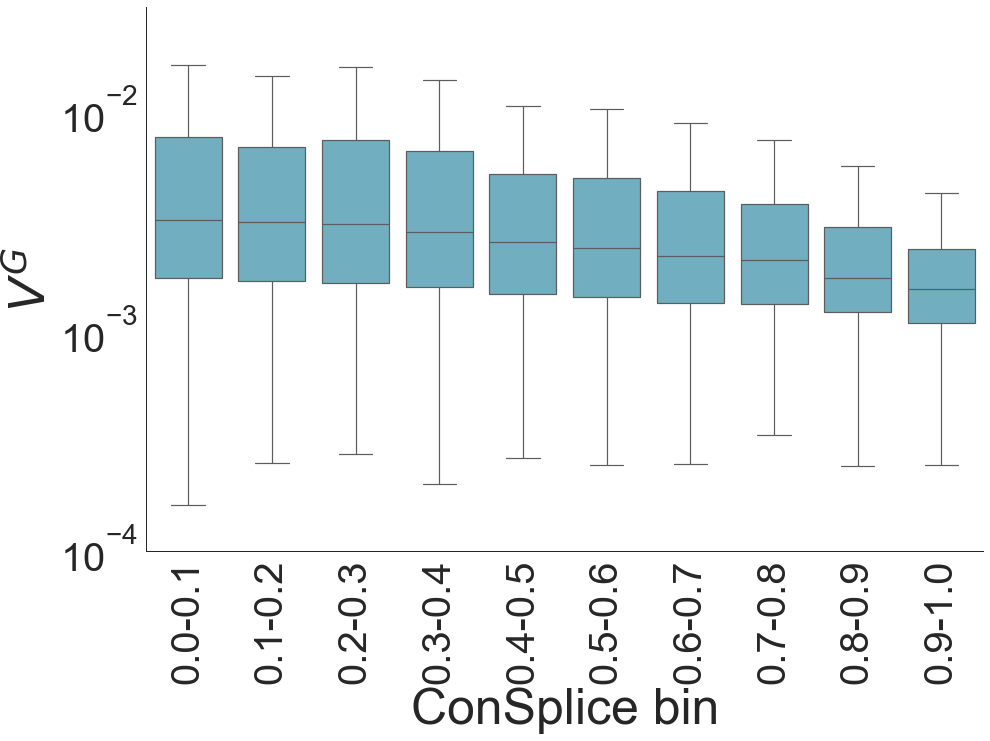

In [19]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


order = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]
box_plot = sns.boxplot(x = "constraint_percentile_bin", 
                       y = "Avg_VG", 
                       data = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].sort_values(by = "constraint_percentile_bin"),
                       order = order,
                       showfliers=False,
                       color = sns.color_palette()[9],
                       ax = ax)

labels = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].groupby("constraint_percentile_bin").Avg_VG.count().tolist()


ax.set_yscale("log")


ax.tick_params(axis="x", labelsize=40, rotation= 90)
ax.tick_params(axis="y", labelsize=40)    

plt.ylim(0.0001, 0.03)
plt.ylabel("$V^G$", fontsize = 50)
plt.xlabel("ConSplice bin", fontsize = 50)

plt.savefig('../figures/figure2_B.svg')

In [17]:
## Get mean vG values for each bin
mean_vg_by_bin = vg_df[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].groupby("constraint_percentile_bin").Avg_VG.mean()

In [18]:
print("Mean fold difference between lowest (0.0-0.1) and highest (0.9-1.0) ConSplice bin: {}".format(mean_vg_by_bin["0.0-0.1"] / mean_vg_by_bin["0.9-1.0"]))

Mean fold difference between lowest (0.0-0.1) and highest (0.9-1.0) ConSplice bin: 4.231043256880445
